# Brain Tumor Classification - noDA

##Mount no Colab

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True )

True
Mounted at /content/drive


## Imports
---


In [3]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, model_selection
from skimage import io
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, datasets, utils

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Configurações para Reprodutibilidade


In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Acesso a GPU
---


In [5]:
# Verifica se a GPU está disponível
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [6]:
!nvidia-smi

Tue Nov 25 02:59:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
if IN_COLAB:
    ds_path = '/content/drive/My Drive/brain_cancer_Unified'

EXP_PATH = './exp-02-4/'
if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

In [8]:
# Nomes das classes
class_names = os.listdir(ds_path)

# Número de classes. Equivale ao número de subpastas na pasta do dataset.
num_classes = len(class_names)
print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 4
Classes: ['glioma', 'pituitary', 'meningioma', 'notumor']


## Hiperparâmetros e Configurações
---

In [9]:
# Tamanho do lote (mini-batch)
batch_size = 64
# Taxa de aprendizado
lr = 0.0001
# Mommentum
mm = 0.9
# Número de épocas
epochs = 50
# Step size
ss = 10

In [10]:
ARCH_NAME = 'resnet18'

## Preparando o conjunto de dados
---

In [11]:
class BrainDataset(Dataset):

    def __init__(self, path_list, label_list, transforms=None):
        self.path_list = path_list
        self.label_list = label_list
        self.transforms = transforms

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        path = self.path_list[idx]
        image = Image.open(self.path_list[idx])

        label = self.label_list[idx]

        if self.transforms:
            image = self.transforms(image)

        return (image, label, path)

In [12]:
data_transforms_train = transforms.Compose([
                                            # Convert image to RGB to ensure 3 channels
                                            transforms.Lambda(lambda img: img.convert('RGB')),
                                            ### transforms.Resize(size=(224, 224)),
                                            transforms.CenterCrop(size=224),
                                            transforms.ToTensor(),
                                            # Normalização. Média e desvio padrão do ImageNet.
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                           ])

data_transforms_test = transforms.Compose([# Convert image to RGB to ensure 3 channels
                                           transforms.Lambda(lambda img: img.convert('RGB')),
                                           # Resimensiona as imagens para o tamanho da entrada da rede.
                                           ### transforms.Resize(size=(224, 224)),
                                           transforms.CenterCrop(size=224),
                                           transforms.ToTensor(),
                                           # Média e desvio padrão do ImageNet.
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                          ])

In [13]:
# Lista com todos os caminhos para as imagens e respectivos rótulos
path_list = []
label_list = []

# Itera ao longo das pastas das classes
for class_ in class_names:
    # Lista ordenada dos arquivos (imagens) em cada pasta
    path_list_ = os.listdir(os.path.join(ds_path, class_))
    path_list_.sort()

    # Itera ao longo dos arquivos na pasta atual (classe)
    for path_image in path_list_:
        file_path = os.path.join(ds_path, class_, path_image)
        path_list.append(file_path)
        label_list.append(class_)

In [14]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
TRAIN_SIZE = 1. - TEST_SIZE - VAL_SIZE

# Dictionary of index labels
le = preprocessing.LabelEncoder()
le.fit(class_names)
label_list_idx = le.transform(label_list)

# Separa TEST_SIZE do conjuto de completo para TESTES. 1. - TEST_SIZE para treinamento 1.
X_train_, X_test, y_train_, y_test = model_selection.train_test_split(path_list,
                                                                      label_list_idx,
                                                                      test_size=TEST_SIZE,
                                                                      stratify=label_list_idx,
                                                                      random_state=42)

# Separa VAL_SIZE do conjuto de completo para TESTES. (VAL_SIZE / TRAIN_SIZE) do conjunto de treinamento 1.
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_,
                                                                  y_train_,
                                                                  test_size=(VAL_SIZE / TRAIN_SIZE),
                                                                  stratify=y_train_,
                                                                  random_state=42)

# Construindo os datasets usando a classe Dataset personalizado.
train_dataset = BrainDataset(X_train, y_train, transforms=data_transforms_train)
val_dataset = BrainDataset(X_val, y_val, transforms=data_transforms_test)
test_dataset = BrainDataset(X_test, y_test, transforms=data_transforms_test)

# Número de imagens em cada dataset
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# DEBUG
print(train_size)
print(val_size)
print(test_size)

3745
1873
1405


In [15]:
# Definindo os dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)

### Visualizing a batch of images

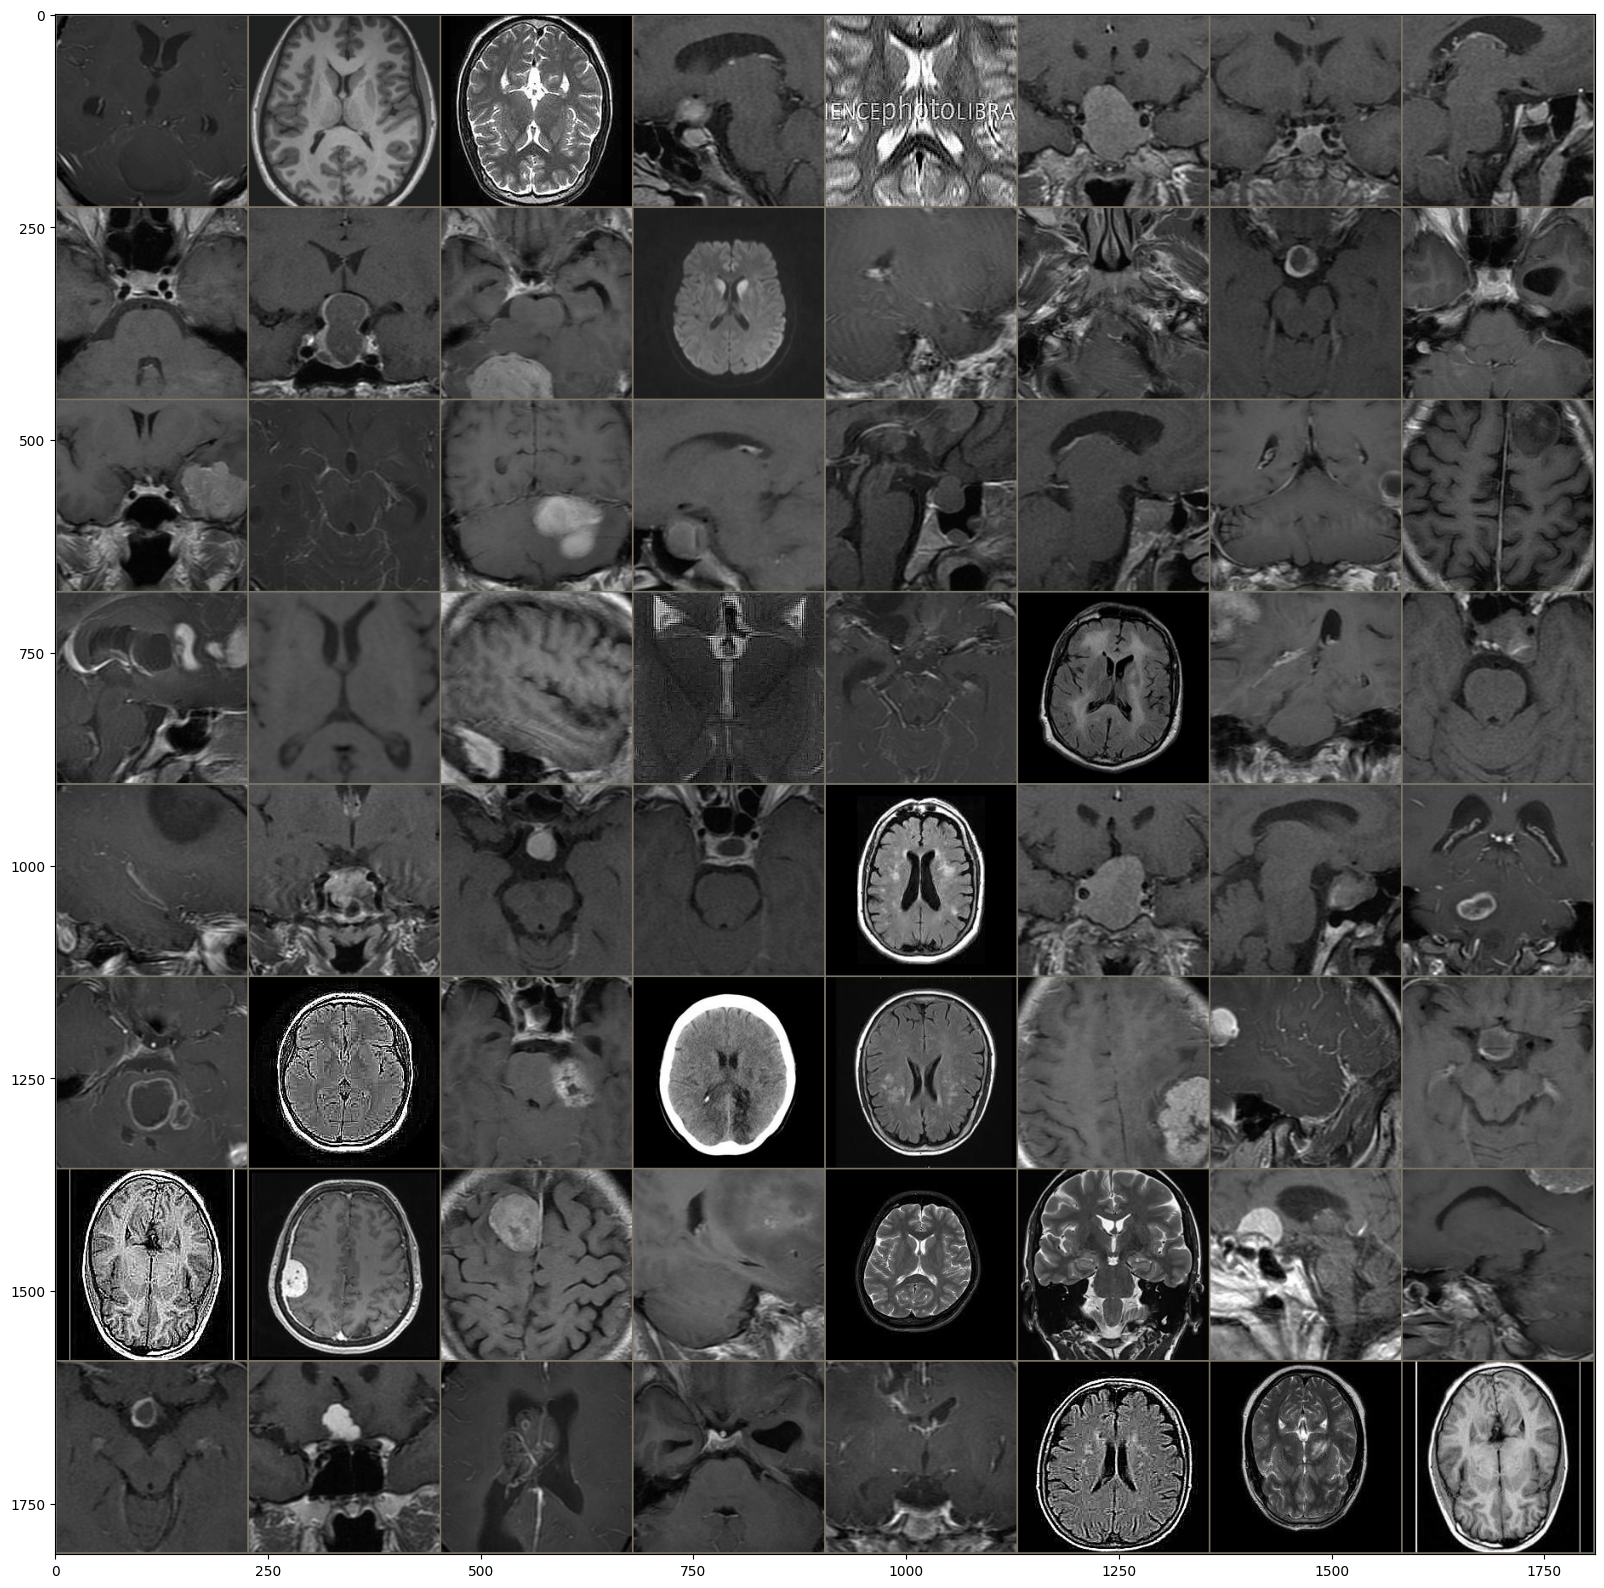

In [16]:
def show_transformed_image(image):
    # Unnormalize the channels. mageNet weights
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)

    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualizar 'batch_size' imagens
dataloader_vis = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
image, label, *_ = next(items)

show_transformed_image(utils.make_grid(image))

plt.savefig(os.path.join(EXP_PATH, 'sample_batch.pdf'))

## A CNN
---

In [17]:
class Net(nn.Module):

    def __init__(self, in_channels, num_classes):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 53 * 53, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        # conv1(x): Input: [224, 224, 3]. Output: [220, 220, 6].
        x = self.conv1(x)
        x = F.relu(x)
        # pool: Input: [220, 220, 6], Output: [110, 110, 6]
        x = self.pool(x)
        # conv2: Input: [110, 110, 6]. Output: [106, 106, 16].
        x = self.conv2(x)
        x = F.relu(x)
        # pool: Input: [106, 106, 16], Output: [53, 53, 16]
        x = self.pool(x)
        # flatten: Input: [53, 53, 16]. Output: [44944]
        x = torch.flatten(x, 1)
        # fc1: Input: [44944]. Output: [120]
        x = self.fc1(x)
        x = F.relu(x)
        # fc2: Input: [120]. Output: [84]
        x = self.fc2(x)
        x = F.relu(x)
        # fc3: Input: [80]. Output: [num_classes]
        x = self.fc3(x)

        return x

## Preparando um modelo Pré-Treinado (fine-tunning)
---


In [18]:
if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(224, num_classes)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Altera o número de neurônios na cadama de saída.
    num_ftrs = model.classifier[6].in_features
    ### model.classifier[6] = nn.Linear(4096, num_classes)
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
    # Altera o número de neurônios na cadama de saída.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

elif ARCH_NAME == 'vit':
    model = models.vit_b_16(weights='ViT_B_16_Weights.DEFAULT')
    num_ftrs = model.heads.head.in_features
    model.heads.head = nn.Linear(num_ftrs, num_classes)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 216MB/s]


In [19]:
# Envia o modelo para a GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda

# Imprime o modelo
print(str(model))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Loss function and optimizer


In [20]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador - SGD
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)
#optimizer = optim.AdamW(model.parameters(), lr=lr)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)


# Adjust learning rate
#scheduler = lr_scheduler.StepLR(optimizer, step_size=ss)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


## Treinamento
---

In [21]:
# Tempo total do treinamento (treinamento e validação)
time_total_start = time.time()

# Lista das perdas (loss) e acurácias (accuracy) de trino para cada época.
train_loss_list = []
train_acc_list = []

# Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
val_loss_list = []
val_acc_list = []

# Learning rate list
lr_list = []

for epoch in range(epochs):
    # TREINAMENTO
    # =========================================================================
    # Inicia contagem de tempo da época
    time_epoch_start = time.time()

    # Habilita o modelo para o modo de treino
    model.train()

    # Perda (loss) nesta época
    loss_epoch_train = 0.0
    # Amostras classificadas corretamente nesta época
    hits_epoch_train = 0

    # Iterate along the batches of the TRAINING SET
    for inputs, labels, *_ in train_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # FORWARD
        # ------>
        # Habilita cálculo do gradiente
        torch.set_grad_enabled(True)

        # Saída do modelo para o lote
        outputs = model(inputs)

        #  Tomar o maior valor de 'outputs' como predição.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward()

        # Atualiza os parâmetros da rede
        optimizer.step()

        # Atualiza a perda da época
        loss_epoch_train += float(loss.item()) * inputs.size(0)

        # Atualiza o número de amostras classificadas corretamente na época.
        hits_epoch_train += torch.sum(preds == labels.data)

    # Perda desta época
    train_loss = loss_epoch_train / train_size
    # Acurácia desta época
    train_acc = float(hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDAÇÃO
    # =========================================================================
    model.eval()

    # Epoch validation loss
    loss_epoch_val = 0.0 #
    # Num hits for this epoch
    hits_epoch_val = 0

    # Iterate along the batches of the VALIDATION SET
    for inputs, labels, *_ in val_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # Desabilita o cálculo do gradiente durante a validação.
        torch.set_grad_enabled(False)

        # Gero um tensor cujas linhas representam o tamanho do "batch" do input
        outputs = model(inputs)

        # Retorna o maior valor como predição.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # Atualiza a perda da época
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # Atualiza os acertos da época
        hits_epoch_val += torch.sum(preds == labels.data)

    # Ajusta o learning rate
    scheduler.step()

    # Store the learning rate
    lr_epoch = optimizer.param_groups[0]['lr']
    lr_list.append(lr_epoch)

    # Perda e acuracia do conjunto de validacao para esta época
    val_loss = loss_epoch_val / val_size
    val_acc = float(hits_epoch_val.double() / val_size)

    # Store val loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Tempo total desta época
    time_epoch = time.time() - time_epoch_start

    # PRINTING
    # --------
    print(f'Epoch {epoch}/{ epochs - 1} - TRAIN Loss: {train_loss:.4f} TRAIN Acc: {train_acc:.4f} - VAL. Loss: {val_loss:.4f} VAL. Acc: {val_acc:.4f} ({time_epoch:.4f} seconds)')

# Tempo total do treinamento
time_total_train = time.time() - time_total_start

# PRINTING
print(f'\nTreinamento finalizado. ({int(time_total_train // 60)}m and {int(time_total_train % 60)}s)')

Epoch 0/49 - TRAIN Loss: 0.3397 TRAIN Acc: 0.8708 - VAL. Loss: 0.1714 VAL. Acc: 0.9386 (2543.5145 seconds)
Epoch 1/49 - TRAIN Loss: 0.0520 TRAIN Acc: 0.9880 - VAL. Loss: 0.1103 VAL. Acc: 0.9632 (40.0786 seconds)
Epoch 2/49 - TRAIN Loss: 0.0132 TRAIN Acc: 0.9989 - VAL. Loss: 0.1100 VAL. Acc: 0.9648 (40.0640 seconds)
Epoch 3/49 - TRAIN Loss: 0.0065 TRAIN Acc: 0.9992 - VAL. Loss: 0.1143 VAL. Acc: 0.9626 (40.2270 seconds)
Epoch 4/49 - TRAIN Loss: 0.0042 TRAIN Acc: 0.9997 - VAL. Loss: 0.1073 VAL. Acc: 0.9674 (40.4074 seconds)
Epoch 5/49 - TRAIN Loss: 0.0029 TRAIN Acc: 1.0000 - VAL. Loss: 0.1059 VAL. Acc: 0.9712 (40.2621 seconds)
Epoch 6/49 - TRAIN Loss: 0.0015 TRAIN Acc: 1.0000 - VAL. Loss: 0.1048 VAL. Acc: 0.9696 (40.6474 seconds)
Epoch 7/49 - TRAIN Loss: 0.0012 TRAIN Acc: 1.0000 - VAL. Loss: 0.1097 VAL. Acc: 0.9680 (40.6106 seconds)
Epoch 8/49 - TRAIN Loss: 0.0013 TRAIN Acc: 1.0000 - VAL. Loss: 0.1060 VAL. Acc: 0.9701 (40.0384 seconds)
Epoch 9/49 - TRAIN Loss: 0.0009 TRAIN Acc: 1.0000 - V

## Salvando o modelo treinado

In [22]:
torch.save(model, os.path.join(EXP_PATH, 'model.pth'))

## Análise do treino
---

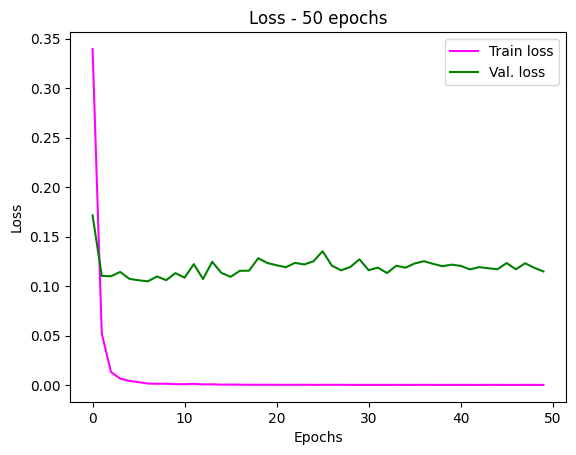

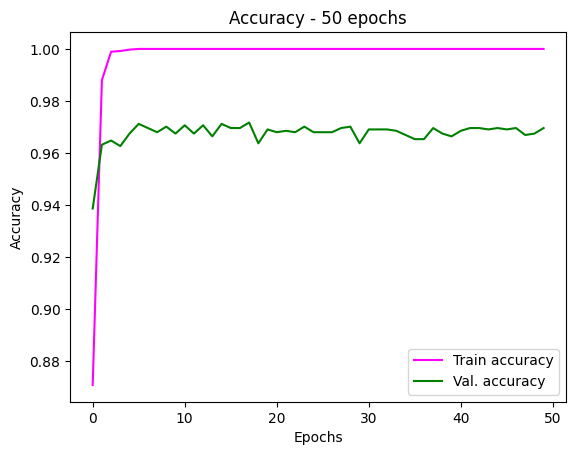

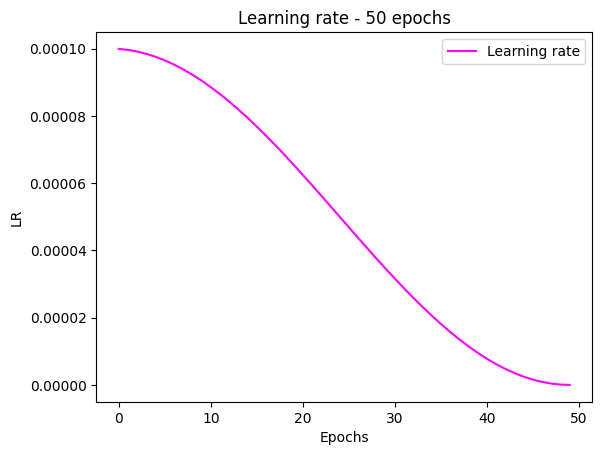

In [23]:
# Lista com os indices das épocas. [0, 1, ... num_epochs - 1]
epochs_list = []
for i in range(len(train_loss_list)):
    epochs_list.append(i)

# Plot - Loss
plt.figure()
plt.title(f'Loss - {epochs} epochs')
plt.plot(epochs_list, train_loss_list, c='magenta', ls='-', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green', ls='-', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'loss_history.pdf'))

# Plot - Accuracy
plt.figure()
plt.title(f'Accuracy - {epochs} epochs')
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train accuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'acc_history.pdf'))

# Plot - LR
plt.figure()
plt.title(f'Learning rate - {epochs} epochs')
plt.plot(epochs_list, lr_list, c='magenta' ,ls='-', label='Learning rate', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('LR')
plt.legend(loc='best')
plt.savefig(os.path.join(EXP_PATH, 'lr_history.pdf'))

## Evaluating the model over the test set
---

In [24]:
# Lista com as classes reais e classes preditas
true_test_list = []
pred_test_list = []
# Lista com as probabilidades
prob_test_list = []
# lista com os caminhos para as imagens
path_test_list = []

# Iterate along the batches of the TEST SET
for i, (img_list, label_list, path_list) in enumerate(test_dataloader):

    if DEVICE.type == 'cuda':
        img_list = img_list.to(DEVICE)
        label_list = label_list.to(DEVICE)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Saída do modelo
    outputs = model(img_list)

    # Predição
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    ### prob_test_batch = np.asarray(outputs_prob.cpu())
    prob_test_batch = list(outputs_prob.cpu())

    # Classes reais (true) e classes preditas (pred) para este lote.
    if DEVICE.type == 'cuda':
        true_test_batch = list(label_list.cpu())
        pred_test_batch = list(preds.cpu())
    else:
        true_test_batch = list(label_list)
        pred_test_batch = list(preds)

    # Append batch results to the lists
    true_test_list += true_test_batch
    pred_test_list += pred_test_batch

    prob_test_list += prob_test_batch
    path_test_list += path_list

## Matriz de Confusão e Relatório da Classificação
---

In [25]:
# Confusion matrix
conf_mat_test = metrics.confusion_matrix(true_test_list, pred_test_list)
print('\nConfusion matrix (test set)')
print(conf_mat_test)

# Classification report - Scikit-learn
class_rep_test = metrics.classification_report(true_test_list,
                                               pred_test_list,
                                               target_names=class_names,
                                               digits=4,
                                               zero_division=0)
print('\nClass. report (test set)')
print(class_rep_test)

# Accuracy
acc_test = metrics.accuracy_score(true_test_list, pred_test_list)
print('\n\nTest Acc.: {:.4f}'.format(acc_test))


Confusion matrix (test set)
[[309  15   0   0]
 [  3 310   9   7]
 [  0   3 394   3]
 [  1   3   0 348]]

Class. report (test set)
              precision    recall  f1-score   support

      glioma     0.9872    0.9537    0.9702       324
   pituitary     0.9366    0.9422    0.9394       329
  meningioma     0.9777    0.9850    0.9813       400
     notumor     0.9721    0.9886    0.9803       352

    accuracy                         0.9687      1405
   macro avg     0.9684    0.9674    0.9678      1405
weighted avg     0.9688    0.9687    0.9687      1405



Test Acc.: 0.9687


##Exportação dos Resultados

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SAVE_DIR = "/content/drive/MyDrive/results_cv"
os.makedirs(SAVE_DIR, exist_ok=True)

def evaluate_and_export_metrics(model, test_dataloader, class_names, prefix="resnet"):
    model.eval()

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for imgs, labels, _ in test_dataloader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(imgs)
            preds = outputs.argmax(1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # ============================================
    #  MATRIZ DE CONFUSÃO
    # ============================================
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predição")
    plt.ylabel("Classe Real")
    plt.title(f"Matriz de Confusão - {prefix}")

    cm_path = f"{SAVE_DIR}/{prefix}_confusion_matrix.png"
    plt.savefig(cm_path, dpi=200, bbox_inches="tight")
    plt.close()
    print(f"Matriz de confusão salva em: {cm_path}")

    # ============================================
    #  METRICAS → CSV
    # ============================================
    report_dict = classification_report(
        true_labels,
        pred_labels,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    accuracy = accuracy_score(true_labels, pred_labels)
    report_dict["accuracy"] = {"value": accuracy}

    metrics_df = pd.DataFrame(report_dict).transpose()

    metrics_path = f"{SAVE_DIR}/{prefix}_metrics.csv"
    metrics_df.to_csv(metrics_path)
    print(f"Métricas salvas em: {metrics_path}")

    return metrics_df, cm


# ===============================
# EXECUTAR
# ===============================
metrics_df, cm = evaluate_and_export_metrics(model, test_dataloader, class_names, prefix="resnet-noda")




Matriz de confusão salva em: /content/drive/MyDrive/results_cv/resnet-noda_confusion_matrix.png
Métricas salvas em: /content/drive/MyDrive/results_cv/resnet-noda_metrics.csv
